In [33]:
import numpy as np
import pandas as pd
### Pipeline
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import  VarianceThreshold, SelectKBest, SelectFromModel
from sklearn.metrics import make_scorer, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from Featurizing import features

In [34]:
# Define X, y datasets
X=features.drop(["target", "application_id"], axis=1)
y=features[['target']]["target"]

# Convert bool to category
for col in X.columns:
    if X[col].dtype == 'bool':
        X[col] = X[col].astype('category')

In [35]:
# Identify numeric columns
num_cols = X.select_dtypes(include=np.number).columns

# Identify 'category' columns
cat_cols = X.select_dtypes(include='category').columns

##### Get the list of column names according the new columns order ######
cols = pd.Index(num_cols.to_list()+cat_cols.to_list())

# Ordenar features de X
X_input = X[cols]
X_input.head()

,num_prev_contracts,avg_notional,pct_late_payments,internal_credit_payments,open_accounts,closed_accounts,max_credit_amount,current_balance,past_due_balance,total_credit_payments,...,credit_type_Otros (Múltiples Créditos),credit_type_Préstamo de Nomina,credit_type_Préstamo Empresarial,credit_type_Préstamo Garantizado,credit_type_Préstamo Personal,credit_type_Préstamo Quirografiario,credit_type_Préstamo no garantizado,credit_type_Préstamo para estudiante,credit_type_Tarjeta Departamental,credit_type_Tarjeta de Crédito
0,15,113217.391304,0.000000,23,17,8,138000.0,192232,0,90.0,...,False,False,False,False,True,False,False,False,False,True
1,0,80000.000000,0.500000,4,8,14,232968.0,104043,19868,535.0,...,True,False,False,False,False,False,False,False,False,True
2,10,188294.736842,0.210526,19,10,14,285500.0,407740,0,404.0,...,True,False,False,False,True,False,False,False,False,True
3,9,30000.000000,0.096774,31,9,14,147066.0,81941,1000,499.0,...,True,False,False,False,True,False,False,False,False,True
4,0,80000.000000,0.000000,5,11,9,80000.0,176484,0,783.0,...,True,False,False,False,True,False,False,False,False,True


In [36]:
# Get the indices of the categorical columns in imputed_cols
cat_index = [cols.get_loc(col) for col in cat_cols]

In [37]:
# Define the categorical and numerical transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine the transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

# Create the pipeline with a SMOTE transformation, a logistic regression estimator,
# and a Sequential Feature Selector
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('undersampling', RandomUnderSampler()),
                       ('variance', VarianceThreshold(0.16)),
                       ('selector', SelectKBest()),
                       ('classifier', LogisticRegression())])

# Create the pipeline with a SMOTE transformation, a random forest estimator,
# and a SequentialFeatureSelector
full_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('undersampling', RandomUnderSampler()),
                       ('variance', VarianceThreshold(0.16)),
                       ('selector', SelectFromModel(DecisionTreeClassifier(max_depth=10, min_samples_split=10))),
                       ('classifier', RandomForestClassifier())])

In [38]:
# Set hyperparameter grid logistic regression
hyperparameters = {'selector__k': [2, 4, 7, 10, 13, 16, 20]}

# Define a function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    return specificity

# Make a scorer from the custom specificity function
specificity_scorer = make_scorer(specificity, greater_is_better=True)

grid_search = GridSearchCV(pipe, hyperparameters, cv=5, scoring=specificity_scorer, verbose=3)
grid_search.fit(X_input, y)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 1/5] END .....................selector__k=2;, score=0.419 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/5] END .....................selector__k=2;, score=0.662 total time=   0.1s
[CV 3/5] END .....................selector__k=2;, score=0.483 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/5] END .....................selector__k=2;, score=0.408 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 5/5] END .....................selector__k=2;, score=0.612 total time=   0.1s
[CV 1/5] END .....................selector__k=4;, score=0.500 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/5] END .....................selector__k=4;, score=0.595 total time=   0.0s
[CV 3/5] END .....................selector__k=4;, score=0.626 total time=   0.0s
[CV 4/5] END .....................selector__k=4;, score=0.565 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 5/5] END .....................selector__k=4;, score=0.537 total time=   0.0s
[CV 1/5] END .....................selector__k=7;, score=0.486 total time=   0.0s
[CV 2/5] END .....................selector__k=7;, score=0.581 total time=   0.0s
[CV 3/5] END .....................selector__k=7;, score=0.531 total time=   0.0s
[CV 4/5] END .....................selector__k=7;, score=0.571 total time=   0.0s
[CV 5/5] END .....................selector__k=7;, score=0.558 total time=   0.0s
[CV 1/5] END ....................selector__k=10;, score=0.473 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/5] END ....................selector__k=10;, score=0.568 total time=   0.0s
[CV 3/5] END ....................selector__k=10;, score=0.544 total time=   0.0s
[CV 4/5] END ....................selector__k=10;, score=0.565 total time=   0.0s
[CV 5/5] END ....................selector__k=10;, score=0.592 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/5] END ....................selector__k=13;, score=0.500 total time=   0.0s
[CV 2/5] END ....................selector__k=13;, score=0.568 total time=   0.0s
[CV 3/5] END ....................selector__k=13;, score=0.497 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/5] END ....................selector__k=13;, score=0.626 total time=   0.0s
[CV 5/5] END ....................selector__k=13;, score=0.558 total time=   0.0s
[CV 1/5] END ....................selector__k=16;, score=0.527 total time=   0.0s
[CV 2/5] END ....................selector__k=16;, score=0.662 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/5] END ....................selector__k=16;, score=0.551 total time=   0.0s
[CV 4/5] END ....................selector__k=16;, score=0.571 total time=   0.0s
[CV 5/5] END ....................selector__k=16;, score=0.605 total time=   0.0s
[CV 1/5] END ....................selector__k=20;, score=0.480 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/5] END ....................selector__k=20;, score=0.561 total time=   0.0s
[CV 3/5] END ....................selector__k=20;, score=0.612 total time=   0.0s
[CV 4/5] END ....................selector__k=20;, score=0.646 total time=   0.0s
[CV 5/5] END ....................selector__k=20;, score=0.531 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['num_prev_contracts', 'avg_notional', 'pct_late_payments',
       'internal_credit_payments', 'open_accounts', 'closed_accounts',
       'max_credit_amount', 'current_balance', 'past_due_balan...
       'credit_type_Préstamo para estudiante',
       'credit_type_Tarjeta Departamental', 'credit_type_Tarjeta de Crédito'],
      dtype='object'))]

In [62]:
import pyperclip

# Copia la lista de columnas al portapapeles
pyperclip.copy(str(cols))


     -------------------------------------- 70.9/70.9 kB 962.5 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 8.0/8.0 MB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 75.4/75.4 kB 2.1 MB/s eta 0:00:00
   ---------------------------------------- 44.0/44.0 kB 2.1 MB/s eta 0:00:00
  Created wheel for paperclip: filename=paperclip-2.7.2-py3-none-any.whl size=118791 sha256=d23b4e0d2b27c9138a090f4153c62de19d2f188b285f17e609d92608bada7531
  Stored in directory: c:\users\aldoernestoescobedot\appdata\local\pip\cache\wheels\8c\eb\25\f9b7ed54717eb792f7c0069fbd87cb32b06cefb58ce70ccc0e
Successfully built paperclip



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
pip install pyperclip

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11123 sha256=dd071d223bf80b61b6b243b6524f94a713694d44e0a30c0539dd47d713cd6bcc
  Stored in directory: c:\users\aldoernestoescobedot\appdata\local\pip\cache\wheels\0c\09\9e\49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
# Set hyperparameter grid random forest with K best
hyperparameters = {'selector__threshold': ["1.5*mean", "median", "1.5*median"],
                       'classifier__n_estimators': [100, 200],
                        'classifier__max_depth': [5,10, 15],
                        'classifier__min_samples_split': [10, 20, 30]}

full_grid_search = GridSearchCV(full_pipe, hyperparameters, cv=4, scoring=specificity_scorer, verbose=3)
full_grid_search.fit(X_input, y)

Fitting 4 folds for each of 54 candidates, totalling 216 fits


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.546 total time=   0.3s
[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.511 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.636 total time=   0.1s
[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.527 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.562 total time=   0.1s
[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.538 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.511 total time=   0.1s
[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.571 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.470 total time=   0.0s
[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.554 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.495 total time=   0.0s
[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.576 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.503 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.538 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.549 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.478 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.573 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.511 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.533 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.533 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.551 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.592 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.592 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.560 total time=   0.1s
[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.497 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.505 total time=   0.0s
[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.527 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.565 total time=   0.0s
[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.519 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.538 total time=   0.0s
[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.565 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.592 total time=   0.0s
[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.584 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.533 total time=   0.0s
[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.484 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.549 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.535 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.598 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.500 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.505 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.470 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.505 total time=   0.1s
[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.560 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.522 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.573 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.500 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.592 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.543 total time=   0.1s
[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.465 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.571 total time=   0.0s
[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.511 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.576 total time=   0.0s
[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.541 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.554 total time=   0.0s
[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.582 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.554 total time=   0.0s
[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.508 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.516 total time=   0.1s
[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.576 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.538 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.524 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.522 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.549 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.543 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.562 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.549 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.500 total time=   0.1s
[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.549 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.562 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.543 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.505 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=5, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.565 total time=   0.1s
[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.573 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.565 total time=   0.0s
[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.614 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.473 total time=   0.0s
[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.530 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.560 total time=   0.0s
[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.549 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.500 total time=   0.0s
[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.589 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.549 total time=   0.0s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.495 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.527 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.508 total time=   0.5s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.560 total time=   0.5s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.554 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.484 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.530 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.538 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.554 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.467 total time=   0.5s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.541 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.505 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.511 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.527 total time=   0.3s
[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.632 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.516 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.565 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.505 total time=   0.1s
[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.557 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.527 total time=   0.2s
[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.533 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.565 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.622 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.495 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.516 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.511 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.551 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.516 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.565 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.565 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.535 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.571 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.522 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.592 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.541 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.560 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.592 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.582 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.465 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.538 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.484 total time=   0.2s
[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.522 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.481 total time=   0.2s
[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.592 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.598 total time=   0.1s
[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.533 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.568 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.565 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.522 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.533 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.551 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.511 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.511 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.543 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.584 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.505 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.543 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.609 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.600 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.527 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.500 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=10, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.516 total time=   0.3s
[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.503 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.565 total time=   0.1s
[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.543 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.505 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.605 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.527 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.538 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=median;, score=0.554 total time=   0.1s
[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.627 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.603 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.522 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.489 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.519 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.446 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.609 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.538 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.568 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.543 total time=   0.6s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.576 total time=   0.5s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=median;, score=0.576 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.573 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.538 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.554 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=10, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.451 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.627 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.516 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.462 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.598 total time=   0.1s
[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.595 total time=   0.1s
[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.630 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.587 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=median;, score=0.614 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.546 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.549 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.543 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.489 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.546 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.511 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.533 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.587 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.589 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.582 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.554 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=median;, score=0.620 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.584 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.495 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.511 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=20, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.533 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.530 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.511 total time=   0.1s
[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.533 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*mean;, score=0.511 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.546 total time=   0.2s
[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.527 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.560 total time=   0.2s
[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=median;, score=0.489 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.578 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.511 total time=   0.2s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.571 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=100, selector__threshold=1.5*median;, score=0.554 total time=   0.1s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.562 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.549 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.516 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*mean;, score=0.538 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.535 total time=   0.5s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.565 total time=   0.5s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.571 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=median;, score=0.511 total time=   0.3s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 1/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.530 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 2/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.505 total time=   0.5s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 3/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.582 total time=   0.4s


c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_

[CV 4/4] END classifier__max_depth=15, classifier__min_samples_split=30, classifier__n_estimators=200, selector__threshold=1.5*median;, score=0.609 total time=   0.3s


GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['num_prev_contracts', 'avg_notional', 'pct_late_payments',
       'internal_credit_payments', 'open_accounts', 'closed_accounts',
       'max_credit_amount', 'current_balance', 'past_due_balan...
                                        SelectFromModel(estimator=DecisionTreeClassifier(max_depth=10,
                                              

In [40]:
grid_search.best_score_

0.5834160691303548

In [41]:
full_grid_search.best_score_

0.6065290834312573

In [42]:
# Model Coefficients
coeficientes=grid_search.best_estimator_.named_steps['classifier'].coef_

In [43]:
# Classifier
columnas=cols[grid_search.best_estimator_.named_steps['variance'].get_support()]
columnas[grid_search.best_estimator_.named_steps['selector'].get_support()]

Index(['num_prev_contracts', 'avg_notional', 'pct_late_payments',
       'internal_credit_payments', 'max_credit_amount', 'current_balance',
       'past_due_balance', 'past_due_ratio', 'current_balance_ratio',
       'institution_FINANCIERA', 'institution_OTRAS FINANCIERA',
       'institution_SERVICIO DE TELEVISION DE PAGA', 'institution_SERVICIOS',
       'institution_TIENDA', 'account_type_Hipoteca',
       'credit_type_Otros (Múltiples Créditos)'],
      dtype='object')

In [44]:
# Classifier
columnas=cols[full_grid_search.best_estimator_.named_steps['variance'].get_support()]
col_random_forest = columnas[full_grid_search.best_estimator_.named_steps['selector'].get_support()]
col_random_forest

Index(['num_prev_contracts', 'avg_notional', 'pct_late_payments',
       'internal_credit_payments', 'open_accounts', 'closed_accounts',
       'max_credit_amount', 'current_balance', 'total_credit_payments',
       'worst_delinquency_past_due_balance', 'credit_limit', 'past_due_ratio',
       'current_balance_ratio', 'credit_type_Otros (Múltiples Créditos)'],
      dtype='object')

In [45]:
full_grid_search.best_params_

{'classifier__max_depth': 15,
 'classifier__min_samples_split': 20,
 'classifier__n_estimators': 100,
 'selector__threshold': 'median'}

## Evaluation

c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
916    1.0
917    1.0
918    1.0
919    1.0
920    1.0
Name: target, Length: 921, dtype: float64


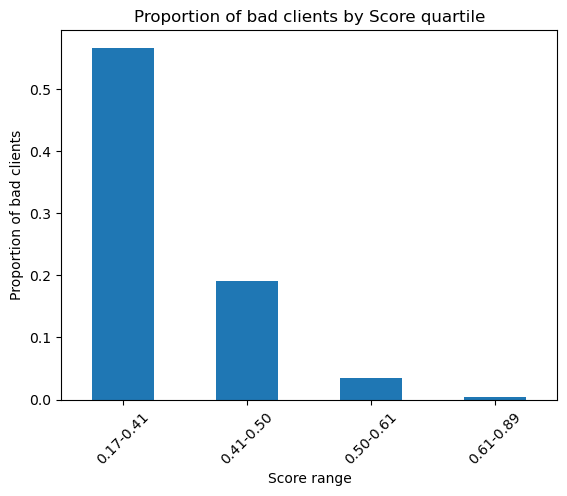

In [46]:
import matplotlib.pyplot as plt
# Generate scores for all examples using the predict_proba method for category '0' of y
scores = full_grid_search.predict_proba(X)
print(y)
# Create a dataframe containing the scores and target variable
data = pd.DataFrame({'score': scores[:, 0], 'target': y})

# Divide the scores into deciles and get the bin labels
data['decile'], bins = pd.qcut(data['score'], 4, labels=False, retbins=True)

# Calculate the proportion of examples with target '1' in each decile
prop = data.groupby('decile')['target'].mean()

# Create a bar plot showing the proportion of examples with target '1' in each decile
ax = prop.plot(kind='bar')
plt.xlabel('Score range')
plt.ylabel('Proportion of bad clients')

# Set the xtick labels to show the range of values for each decile
ax.set_xticklabels([f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)])

plt.title("Proportion of bad clients by Score quartile")
# Rotate the xtick labels by 90 degrees
plt.xticks(rotation=45)

plt.show()

c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


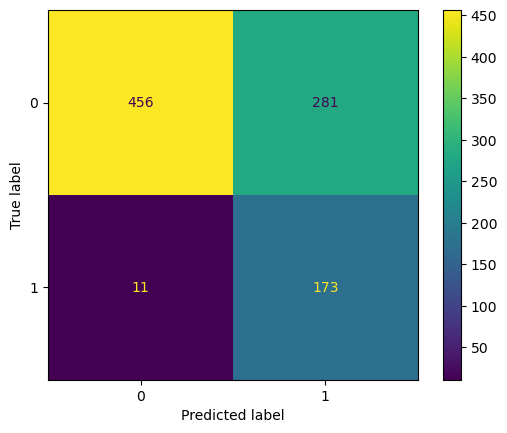

In [47]:
ConfusionMatrixDisplay(confusion_matrix(y, full_grid_search.predict(X), )).plot()

In [48]:
specificity(y, grid_search.predict(X))

c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


0.5739484396200815

In [49]:
specificity(y, full_grid_search.predict(X))

c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\AldoErnestoEscobedoT\anaconda3\lib\site-packages\sklearn\utils\validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


0.6187245590230664

## Save the model

In [50]:
import pickle

with open('classification_model.pkl', 'wb') as file:
    pickle.dump(grid_search, file)


(array([  5.,  17.,  36., 100., 219., 249., 187.,  74.,  24.,  10.]),
 array([0.00933424, 0.10382422, 0.19831421, 0.29280419, 0.38729418,
        0.48178416, 0.57627415, 0.67076413, 0.76525412, 0.8597441 ,
        0.95423409]),
 <BarContainer object of 10 artists>)

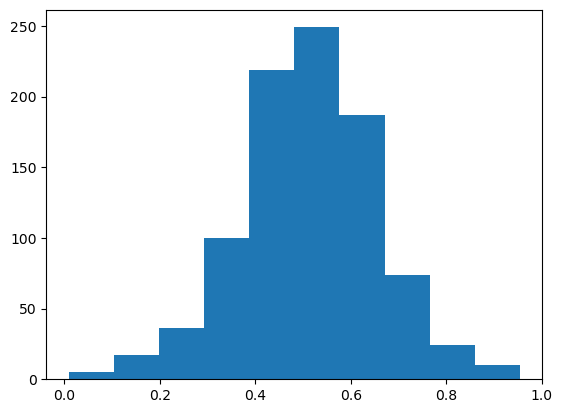

In [67]:
from Inference import scores

plt.hist(scores)